# Reads Assignment

In [1]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
from starmap.sequencing import *
from scipy.io import loadmat
from tqdm import tqdm
import tifffile
from skimage.measure import regionprops

### Functions

In [2]:
from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it

@timer
# Load reads and their positions from mat file
def load_reads(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 2]-1) 
    temp[:, 1] = np.round(points[:, 1]-1)
    temp[:, 2] = np.round(points[:, 0]-1)
    
    print(f"Number of reads: {len(bases)}")
    
    return bases, temp

# Load gene table from genes.csv
def load_genes(fpath):
    genes2seq = {}
    seq2genes = {}
    with open(os.path.join(fpath, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            genes2seq[fields[0]] = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            seq2genes[genes2seq[fields[0]]] = fields[0]
    return genes2seq, seq2genes

# sequencing data

In [3]:
# IO path 
ppath = 'Z:/Data/Processed/2022-10-15-Rena-SkinCulture254-gene/'
opath = os.path.join(ppath, 'output')
areas = range(1,7)

In [4]:
# Load genes
genes2seqs, seqs2genes = load_genes(ppath)
genes = genes2seqs.keys()
genes_to_index = {}  
for i, k in enumerate(genes):
    genes_to_index[k] = i

In [19]:
area_num = 4
# Load reads of current well
bases, points = load_reads(os.path.join(opath, '2022-11-07-merged-points', f'Area{area_num}'), "merged_goodPoints.mat")
bases = np.array([seqs2genes[x] for x in bases])
points = np.array(points)
points = points.astype(int)

Number of reads: 1404691
Total execution time: 11.901 s


====Processing: whole_cell====
Total number of cells: 2310
Getting region information...


100%|██████████| 2310/2310 [02:12<00:00, 17.45it/s]


76.48 % [1074352 out of 1404691] reads were assigned to 2310 cells
====Processing: nucleus====
Getting region information...


100%|██████████| 2310/2310 [00:46<00:00, 50.05it/s]


39.94 % [561020 out of 1404691] reads were assigned to 2310 cells


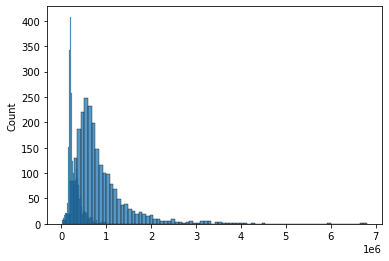

In [20]:
structure_dict = {'whole_cell': 'cell',
                 'nucleus': 'nucleus'}

total_cells = None # NOTE only defined in whole_cell 
# expr_dict = {}

for current_structure in structure_dict.keys():
    # current_structure = 'nucleus'
    print(f"====Processing: {current_structure}====")

    current_out_path = os.path.join(opath, f'Area{area_num}', current_structure)
    if not os.path.exists(current_out_path):
        os.mkdir(current_out_path) 
    
    # Load segmentation
    seg_path = os.path.join(opath, '2022-11-11-3D-segmentation')
    current_seg = tifffile.imread(os.path.join(seg_path, structure_dict[current_structure], f'Area{area_num}_{structure_dict[current_structure]}_3Dseg.tif'))

    # remove reads that fall out of frame
    in_frame = []
    for i, p in enumerate(points):
        if np.any(p >= current_seg.shape):
            in_frame.append(False)
        else: in_frame.append(True)
    points = points[in_frame]
    bases = bases[in_frame]

    # Assign reads to current structure
    reads_assignment = current_seg[points[:, 0], points[:, 1], points[:, 2]]

    if not total_cells:
        total_cells = len(np.unique(current_seg)) - 1
        print(f"Total number of cells: {total_cells}")

    cell_by_barcode = np.zeros((total_cells, len(genes)))

    # Get region information 
    print('Getting region information...') 
    rp = regionprops(current_seg)

    region_labels = []
    areas_dict = []
    cell_locs_dict = []
    for i, region in enumerate(tqdm(rp)):
        region_labels.append(region.label)
        area = region.area
        areas_dict.append(area)
        if area > 0:
            cell_locs_dict.append(region.centroid)
        else: cell_locs_dict.append((0,0,0)) # NOTE to be deleted

        assigned_reads = bases[reads_assignment == i+1]  # i+1 == region label
        for j in assigned_reads:
            if j in genes_to_index:
                cell_by_barcode[i, genes_to_index[j]] += 1 

    cell_by_barcode = cell_by_barcode.astype(int)
    cell_locs_dict = np.array(cell_locs_dict).astype(int) #?
    curr_meta = pd.DataFrame({'sample': area_num, 'area': areas_dict,
                                'x':cell_locs_dict[:, 1], 'y':cell_locs_dict[:, 2], 'z':cell_locs_dict[:, 0]})

    # Output
    with open(os.path.join(current_out_path, "log.txt"), 'w') as f:
        msg = f'{100*cell_by_barcode.sum()/len(bases):.2f} % [{cell_by_barcode.sum()} out of {len(bases)}] reads were assigned to {total_cells} cells'
        print(msg)
        f.write(msg)
    np.savetxt(os.path.join(current_out_path, "cell_barcode_count.csv"), cell_by_barcode, delimiter=',', fmt="%d")
    cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
    cell_barcode_names.to_csv(os.path.join(current_out_path, "cell_barcode_names.csv"), header=False)
    curr_meta.to_csv(os.path.join(current_out_path, "meta.csv"))

    # expr_dict[current_structure] = cell_by_barcode
    # print(curr_meta.head())
    sns.histplot(areas_dict)
    # break

## Generate complete matrix for all samples

In [22]:
# Construct complete matrix # NOTE just to concat samples together
for current_structure in structure_dict.keys():
    print(f"====Generating: {current_structure}====")
    cell_by_gene_complete = None 
    meta_complete = None    

    for i, area_num in enumerate(areas):
        current_expr_path = os.path.join(opath, f'Area{area_num}')
        current_expr = np.loadtxt(os.path.join(current_expr_path, current_structure, "cell_barcode_count.csv"), dtype=int, delimiter=',')
        current_meta = pd.read_csv(os.path.join(current_expr_path, current_structure, "meta.csv")) 

        # add to complete matrix
        if cell_by_gene_complete is not None:
            cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
        else:
            cell_by_gene_complete = current_expr

        if meta_complete is not None:
            meta_complete = pd.concat([meta_complete, current_meta])
        else:
            meta_complete = current_meta

    current_output_path = os.path.join(opath, current_structure)
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)
    np.savetxt(os.path.join(current_output_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(int), delimiter=',', fmt="%d")
    meta_complete = meta_complete.reset_index(drop=True)
    meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
    meta_complete.to_csv(os.path.join(current_output_path, "complete_meta.csv"))
    # cell_barcode_names.to_csv(os.path.join(current_output_path, "cell_barcode_names.csv"), header=False)

====Generating: whole_cell====
====Generating: nucleus====
